In [7]:
# load modules

import numpy as np
import scipy.io as sio
import itertools
import time
import random
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import find
import matplotlib.patches as mpatches

import requests
import io
import zipfile



In [8]:
# get hand data from web and put in your working directory
r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00313/sEMG_Basic_Hand_movements_upatras.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()


In [9]:

def load_hand_signals_five_subjects():
    '''
    Import each subjects' dictionaries into one list.
    Remove any metadata in the dictionaries.
    '''
    subject_signals = []
    
    signal_1 = sio.loadmat(".\Database 1\female_1.mat")
    del signal_1['__header__'] # remove metadata
    del signal_1['__globals__']
    del signal_1['__version__']
    subject_signals.append(signal_1)
    signal_2 = sio.loadmat(".\Database 1\female_2.mat")
    del signal_2['__header__'] 
    del signal_2['__globals__']
    del signal_2['__version__']
    subject_signals.append(signal_2)
    signal_3 = sio.loadmat(".\Database 1\female_3.mat")
    del signal_3['__header__'] 
    del signal_3['__globals__']
    del signal_3['__version__']
    subject_signals.append(signal_3)
    signal_4 = sio.loadmat(".\Database 1\male_1.mat")
    del signal_4['__header__'] 
    del signal_4['__globals__']
    del signal_4['__version__']
    subject_signals.append(signal_4)
    signal_5 = sio.loadmat(".\Database 1\male_2.mat")
    del signal_5['__header__'] 
    del signal_5['__globals__']
    del signal_5['__version__']
    subject_signals.append(signal_5)
    
    return subject_signals

def load_hand_signals_one_subject():
    '''
    Import each subjects' dictionaries into one list
    Remove any metadata in the dictionaries
    '''
    subject_signals = []
    
    signal_1 = sio.loadmat(".\Database 2\male_day_1.mat")
    n = len(signal_1.keys())
    subject_signals.append(dict(itertools.islice(signal_1.items(),3,n))) # the three removes the hand metadata
    signal_2 = sio.loadmat(".\Database 2\male_day_2.mat")
    subject_signals.append(dict(itertools.islice(signal_2.items(),3,n))) 
    signal_3 = sio.loadmat(".\Database 2\male_day_3.mat")
    subject_signals.append(dict(itertools.islice(signal_3.items(),3,n)))
 
    return subject_signals

def get_signal_classes(subject_signals,num_trials):
    '''
    returns a vector of classes where the ith element is the class of 
    the ith signal from the subject_signals dictionary. Note this function 
    returns the specific class and channel of a signal.
    '''
    n = len(subject_signals)
    all_signals_classes = []
    
    for i in range(n):

        current_subject = subject_signals[i]
        class_keys = list(current_subject.keys())
        repeated_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_trials) for x in class_keys)) # repeat each class num_trails times
        all_signals_classes.extend(repeated_list) 
        
    return all_signals_classes

def get_combined_channel_classes(num_trials,num_sessions):
    '''
    returns a vector of combined channel classes for the hand signals. This
    function is invoked independent of the subject_signals dictionary and is 
    written so that the ith signal in the feature vector of signals x has its ith
    class being the ith element of the y returned by this function.
    '''
    y = []
    class_keys_new = ['cyl','hook','tip','palm','spher','lat']
    for i in range(num_sessions):
        repeated_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_trials) for x in class_keys_new))
        y.extend(repeated_list)
    return y

def segment_signal(signal, window_length = 4, overlap_length = 2, copy = False):
    '''
    segment a signal into windows of window_length and which overlap with
    overlap_length. This function returns an array which contains these segments
    as subarrays.
    '''
    sh = (signal.size - window_length + 1, window_length)
    st = signal.strides * 2
    view = np.lib.stride_tricks.as_strided(signal, strides = st, shape = sh)[0::overlap_length] # numpy trick for fast segmentation
    if copy:
        return view.copy()
    else:
        return view

##################################################################################################################
# feature functions
        
def ar_coefficients_stat_models(signal, ar_parameter): # from statmodels
    '''
    return the autoregressive coefficients of a time series (signal in this case).
    Returns ar_parameter number of coefficients and uses the stats_models package
    for this calculation.
    '''
    ar_mod = AR(signal)
    ar_res = ar_mod.fit(ar_parameter,trend='nc') # removes constant term
    ar_coefficients = ar_res.params

    return ar_coefficients.tolist()
    
def wamp_formula(numpy_array, threshold = .00005): 

    n = len(numpy_array)
    wamp=0
    for i in range(n-1):
        if (abs(numpy_array[i]-numpy_array[i+1]) > threshold):
            wamp += 1
    return wamp


def wilson_amplitude(signal_segments): #works, look into threshold
    '''
    Wilson Amplitude is a feature which is the number
    of times that the difference between two consecutive amplitudes
    in a time segment exceeds threshold, which can be anything but set
    here to 50 uV
    '''
    feature_list = list(map(wamp_formula,signal_segments))
        
    return feature_list


def rms_formula(signal):

    rms_of_signal = np.sqrt(np.mean(np.power((signal),2)))

    return rms_of_signal
    
def rms_window(signal_segments): 
    '''
    input: signal_segments is signal split into segments
    output: list containing the rms of each window at each stride
    '''
    feature_list = list(map(rms_formula,signal_segments))

    return feature_list
    

def var_formula(signal):

    return np.var(signal)
    
def variance(signal_segments): 
    '''
    input: signal_segments is signal split into segments
    output: list consisting of the variance of each window at each stride
    '''
    feature_list = list(map(var_formula,signal_segments))

    return feature_list

def wl_formula(signal):

    n = len(signal)
    wl_of_signal = (1/(n-1))*sum(abs(signal[l]-signal[l-1]) for l in range(1,n))

    return wl_of_signal

def waveform_length(signal_segments): 
    '''
    input: signal_segments is signal split into segments
    output: list consisting of the waveform length of each window at each stride
    '''
    feature_list = list(map(wl_formula,signal_segments))

    return feature_list


def mav_formula(signal):

    n = len(signal)
    mav_of_signal = (1/n)*sum(abs(signal[l]) for l in range(n))

    return mav_of_signal


def mean_absolute_value(signal_segments):
    '''
    input: signal_segments is signal split into segments
    output: list consisting of the mean absolute value of each window at each stride
    '''
    
    feature_list = list(map(zc_formula,signal_segments))       
            
    return feature_list   

def zc_formula(numpy_array, threshold = .0005): # 0.05 mV by default 

    n = len(numpy_array)
    zc=0
    for i in range(1,n-1):
        if ((numpy_array[i]-threshold)*(numpy_array[i-1]-threshold) < 0):
            zc += 1
    return zc


def zero_crossing(signal_segments): # works, look into threshold
    '''
    Zero Crossing is a feature which is the number
    of number of times the signal crosses zero on the amplitude
    axis
    '''
    feature_list = list(map(zc_formula,signal_segments))
        
        
    return feature_list

def ssc_formula(numpy_array, threshold = .2*(10**-9)): # 0.2 nV by default 

    n = len(numpy_array)
    ssc=0
    for i in range(1,n-1):
        if (((numpy_array[i]-numpy_array[i-1])*(numpy_array[i]-numpy_array[i+1])) > threshold):
            ssc += 1
    return ssc


def sign_slope_changes2(signal_segments): 
    '''
    '''
    feature_list = list(map(ssc_formula,signal_segments))
        
    return feature_list


def feature_extraction(processed_signals, feature_name_list, window_length = 100, overlap_length = 1, ar_parameter = 0):
    '''
        Input: 1) processed_signals is list of dictionaries: each subject ->
            all his/her signals and associated classes as a dictionary
               2) class_name_list is list of strings, one for each class
               3) feature_name_list is list of features to extract from signals,
               DOES NOT include AR or other non-window features
               4) others self expanatory

        Output: list of all feature representations of the signals
     
        Hand data notes:
        class list: ['cyl_ch1','cyl_ch2','hook_ch1','hook_ch2','tip_ch1','tip_ch2'
        ,'palm_ch1','palm_ch2','spher_ch1','spher_ch2','lat_ch1','lat_ch2']
        
    '''
    ti = time.time()
    
    num_subjects = len(processed_signals)
    num_features = len(feature_name_list)
    num_classes = len(list(processed_signals[0].keys()))
    all_signals_features_list = list([])
    total_current_feature_list = list([])
    
    for i,j in itertools.product(range(num_subjects),range(num_classes)):

        current_subject = processed_signals[i]

        current_class = list(processed_signals[i].keys())[j]

        if ar_parameter != 0: # there are two ar functions used here, from statmodels and spectrum, since statmodels is faster its used here

            total_current_feature_list = list(map(lambda x: ar_coefficients_stat_models(x,ar_parameter),current_subject[current_class]))

        segmented_current_signal = np.array(list(map(lambda x: segment_signal(x,window_length,overlap_length),current_subject[current_class]))) #break signals up into windows
        
        for k in range(num_features):
            
            possibles = globals().copy() # this is a work around to be able to call a function when given its string name
            possibles.update(locals())
            method_to_call = possibles.get(feature_name_list[k]) #call function from feature name list
            current_feature = map(method_to_call, segmented_current_signal)

            if k > 0 or ar_parameter != 0:

                total_current_feature_list = list(map(list, zip(total_current_feature_list,current_feature)))
        
                total_current_feature_list = list(map(lambda x: sum(x, []),total_current_feature_list))
    
            else:

                total_current_feature_list = list(current_feature)
        if j == 0:
            print("Feature Extraction Progress")        
            print("session num: (out of "+str(num_subjects)+")",i+1,"class num: (out of 12) " ,j+1) # optional to see where your at, maybe use for long running feature extraction combos
        all_signals_features_list.extend(total_current_feature_list)

    tf = time.time()
    print("Feature Extraction Total Runtime:" ,(tf-ti)/60,"mins")
    return all_signals_features_list

##################################################################################################################
# classifier functions

def qda():

    return QuadraticDiscriminantAnalysis()

def lda():

    return LinearDiscriminantAnalysis()

def svm():

    return SVC(kernel = 'rbf')

def random_forest():

    return RandomForestClassifier(random_state=5)

def extra_trees():

    return ExtraTreesClassifier(random_state = 10)

def grad_boost():
    
    return GradientBoostingClassifier(random_state = 8)

def classification_train_test(all_signals_fearures_list, all_signals_classes, classifier_string = 'qda'):       
    '''
    This function takes an array of signals (represented by extracted features) and an array of the classes
    corresponding to each signal. Then this function trains the given classifier using the first two days and
    tests the classifier on the last day. The test accuracy as well as a classification report is printed out.
    
    Note: classifier_strings are either qda,lda,svm, random forest, extra trees, and grad_boost as of now
    '''

    train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:1200], all_signals_fearures_list[1200:], all_signals_classes[:1200], all_signals_classes[1200:]

    possibles = globals().copy()
    possibles.update(locals())
    method_to_call = possibles.get(classifier_string) # call function from feature name list
    clf = method_to_call()
    clf.fit(train_sigs, train_sigs_classes)

    prediction_classes = clf.predict(test_sigs) # testing the classifier
    actual_classes = test_sigs_classes 
    
    print("Test accuracy is: ",accuracy_score(prediction_classes, actual_classes),end="\n")
    print(classification_report(actual_classes,prediction_classes))
    
def classification_cross_val(all_signals_fearures_list, all_signals_classes, classifier_string = 'qda', n_splits = 8):       
    '''
    classifier_strings are either qda,lda,svm,random forest, extra trees and gradient boosting as of now
    '''
    random_state_1 = int(random.randint(1,100))
    random_state_2 = int(random.randint(1,100))
     
    # train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = train_test_split(all_signals_fearures_list, all_signals_classes, random_state = random_state_1)    
   
    train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:1200], all_signals_fearures_list[1200:], all_signals_classes[:1200], all_signals_classes[1200:]
    possibles = globals().copy()
    possibles.update(locals())
    method_to_call = possibles.get(classifier_string) # call function from feature name list
    clf = method_to_call()
    #clf.fit(train_sigs, train_sigs_classes)

    #prediction_classes = clf.predict(test_sigs) #testing the classifier
    #actual_classes = test_sigs_classes #testing the classifier

    shuffle = KFold(n_splits, shuffle=True, random_state=random_state_2)
    scores = cross_val_score(clf, all_signals_fearures_list, all_signals_classes, cv=shuffle)

    #print(classification_report(actual_classes, prediction_classes))

    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2),end='\n')

###############################################################################################################
# visualization and dimensionality reduction
    
def visualization(x,y,num_classes,legend=True, method="tsne", n_components=2):
     '''
     Uses dimensionality reduction to visualize a feature matrix x and class vector y. This
     function colors each class a different color and if legend=TRUE, 
     the plot includes a legend which shows which class each color represents. 
     
     Note: can uses t-sne and pca right now. Also n_components must be 2 for now
     '''
     mydict={} # this first chunk of code encodes class strings as numbers
     i = 0
     for item in y:
         if(i>0 and item in mydict):
             continue
         else:    
            i = i+1
            mydict[item] = i

     k=[]
     for item in y:
         k.append(mydict[item])
    
     if method == "tsne":
         Y = TSNE(n_components,init='pca').fit_transform(x) # TSNE function is from sklearn.manifold
         
     elif method == "pca":
         Y = PCA(n_components).fit_transform(x)    
         
     colors = ['red','green','blue','purple','yellow','black',
                   'pink','violet','teal','orchid','lime','cyan','gold','silver','magenta']
     colors = colors[:num_classes]
     plt.scatter(Y[:,0], Y[:,1], c=k, cmap=matplotlib.colors.ListedColormap(colors))     
     frame1 = plt.gca() # gca, gcf used to manipute axes and plot size 
     frame2 = plt.gcf()
     
     frame1.axes.xaxis.set_ticklabels([])  # hide the axis labels and tick marks since they are irrelevant for tsne and pca visualizations
     frame1.axes.yaxis.set_ticklabels([])
     frame1.axes.xaxis.set_ticks([])
     frame1.axes.yaxis.set_ticks([])
     frame2.set_size_inches(10, 10) 
     if legend == True:

         unique_classes = [e for i, e in enumerate(y) if y.index(e) == i]
         recs=[]
         for i in range(0,len(colors)):
             recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i])) # manually add legend

         plt.legend(recs,unique_classes,loc=0,fontsize = 'large') # put legend in 'best' location

     plt.show()
     
def combine_channels(x,num_trials):
    '''
    combines the hand data channels; for instance, cyl_ch1 and cyl_ch2
    turn into cyl. The features vector of cyl_ch1 is appended onto
    the end of feature vector of cyl_ch2 to get feature vector of cyl
    '''
    n = len(x)
    x_new = [0]*int((n/2))
    i = 0
    k = 0
    while i != n: 
        x_new[k]= x[i]+x[i+num_trials]
        i += 1
        k += 1
        if (i+num_trials) % num_trials == 0:
            i = i+num_trials
    return x_new


In [10]:
subjects_signals = load_hand_signals_one_subject() # one subject repeating each movement 100 times
num_trials = 100
num_sessions = 3 # one subject on three different days

features_signals = feature_extraction(subjects_signals,['rms_window',"variance"],window_length = 128, overlap_length = 64,
                                      ar_parameter = 6)

x = combine_channels(features_signals,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)


Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.151344891389211 mins


In [11]:
classification_train_test(x,y, classifier_string = 'grad_boost')

Test accuracy is:  0.67
              precision    recall  f1-score   support

         cyl       0.75      0.73      0.74       100
        hook       0.87      0.84      0.85       100
         lat       0.49      0.82      0.61       100
        palm       0.31      0.15      0.20       100
       spher       0.80      1.00      0.89       100
         tip       0.75      0.48      0.59       100

   micro avg       0.67      0.67      0.67       600
   macro avg       0.66      0.67      0.65       600
weighted avg       0.66      0.67      0.65       600



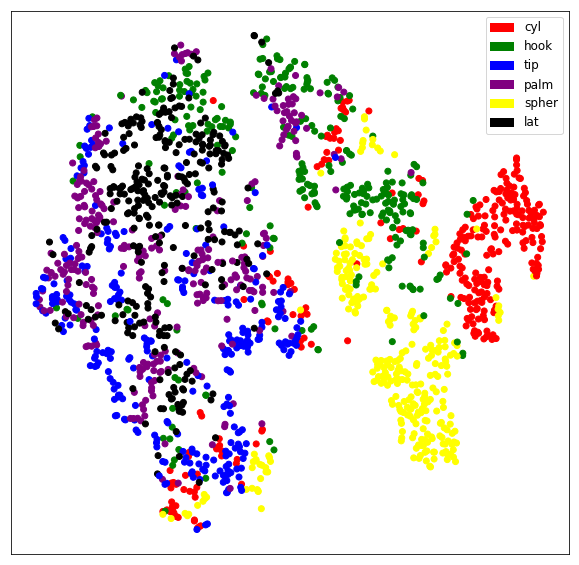

In [12]:
visualization(x,y,num_classes=6,legend=True,method="tsne",n_components=2)